In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Exploring
import scipy.stats as stats
from scipy.stats import chi2_contingency, ttest_ind, pearsonr

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures


from sklearn import *



# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve
%matplotlib inline

import prepare_zillow

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Acquisition, Prep & Initial Exploration


In [2]:
df = prepare_zillow.zillow_csv()
df = prepare_zillow.zillow_ready_to_explore(df)

In [3]:
# Removing outliers 

keys = ['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet',
                      'structuretaxvaluedollarcnt','landtaxvaluedollarcnt', 'regionidzip', 'regionidcounty']
values = [(1,7), (1,7), (500,8000), (25000,2000000), (10000,2500000), (95000, 99999), (3000,3200)]

dictionary = dict(zip(keys, values))

for key, value in dictionary.items():
    df = df[df[key] >= value[0]]
    df = df[df[key] <= value[1]]

In [4]:
# Dropping columns that don't provide information.

df = df.drop(columns=['id', 
                      'parcelid',
                      'transactiondate',
                      'buildingqualitytypeid', 
                      'propertyzoningdesc', 
                      'regionidcity', 
                      'censustractandblock', 
                      'heatingorsystemdesc',
                      'propertycountylandusecode',
                      'rawcensustractandblock',
                      'assessmentyear',
                      'roomcnt',
                      'unitcnt',
                      'Unnamed: 0'])


# Only a few NaN left, dropping.
df.dropna(inplace=True)


# bathroomcnt, calculatedbathnbr and fullbathcnt are all the same numbers
# calculatedfinishedsquarefeet and finishedsquarefeet12 same
df = df.drop(columns=['calculatedbathnbr', 'fullbathcnt', 'finishedsquarefeet12', 'regionidcounty', 'fips'])


In [5]:
float_num = ['bathroomcnt', 
             'bedroomcnt', 
             'latitude', 
             'longitude', 
             'regionidzip', 
             'yearbuilt']

def float_to_int(df: pd.DataFrame, cols: tuple) -> pd.DataFrame:
    to_coerce = {col: 'int' for col in cols}
    return df.astype(to_coerce)

df = float_to_int(df, float_num)


In [6]:
# landuse_encoded 0 = Condominium and 1 = Single Family Residential

le = LabelEncoder()
le.fit(df.propertylandusedesc)
df['landuse_encoded'] = le.transform(df.propertylandusedesc)

df.drop(columns=['propertylandusedesc'], inplace=True)

In [7]:
df_mod = df.copy()

In [8]:
df_mod = df_mod[df_mod['landuse_encoded'] == 1]
df_mod.drop(columns=['landuse_encoded'], inplace= True)

In [9]:
df_mod.drop(columns=['taxamount'], inplace=True)

### Feature Engineering

In [10]:
df_mod['bednbath'] = df.bedroomcnt + df.bathroomcnt
df_mod.drop(columns=['bathroomcnt', 'bedroomcnt'], inplace=True)

In [11]:
df_mod['price_per_sqft_structure'] = df_mod.structuretaxvaluedollarcnt / df_mod.calculatedfinishedsquarefeet
df_mod.drop(columns=['structuretaxvaluedollarcnt', 'calculatedfinishedsquarefeet'], inplace=True)

In [12]:
df_mod['price_per_sqft_land'] = df_mod.landtaxvaluedollarcnt / df_mod.lotsizesquarefeet
df_mod.drop(columns=['landtaxvaluedollarcnt', 'lotsizesquarefeet'], inplace=True)

In [13]:
df_mod['age'] = 2019 - df.yearbuilt
df_mod.drop(columns=['yearbuilt'], inplace=True)


In [14]:
df_mod['log_bin'] = pd.qcut(df_mod.logerror, 4, labels=False)

In [15]:
df_mod['age_bin'] = pd.qcut(df_mod.age, 10, labels=False)

In [16]:
scaler = MinMaxScaler()
scaler.fit(df_mod[['price_per_sqft_structure']])
df_mod.price_per_sqft_structure = scaler.transform(df_mod[['price_per_sqft_structure']])

scaler = MinMaxScaler()
scaler.fit(df_mod[['price_per_sqft_land']])
df_mod.price_per_sqft_land = scaler.transform(df_mod[['price_per_sqft_land']])

scaler = MinMaxScaler()
scaler.fit(df_mod[['taxvaluedollarcnt']])
df_mod.taxvaluedollarcnt = scaler.transform(df_mod[['taxvaluedollarcnt']])

scaler = MinMaxScaler()
scaler.fit(df_mod[['latitude']])
df_mod.latitude = scaler.transform(df_mod[['latitude']])

scaler = MinMaxScaler()
scaler.fit(df_mod[['longitude']])
df_mod.longitude = scaler.transform(df_mod[['longitude']])

scaler = MinMaxScaler()
scaler.fit(df_mod[['bednbath']])
df_mod.bednbath = scaler.transform(df_mod[['bednbath']])

scaler = MinMaxScaler()
scaler.fit(df_mod[['age']])
df_mod.age = scaler.transform(df_mod[['age']])

scaler = MinMaxScaler()
scaler.fit(df_mod[['regionidzip']])
df_mod.regionidzip = scaler.transform(df_mod[['regionidzip']])

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all 

In [17]:
def heatmap_corr(df):
    plt.figure(figsize=(15,15))
    sns.heatmap(df.corr(), cmap='Greens', annot=True)
    
# heatmap_corr(df_mod)

In [18]:
def pairplot_numeric(df):
    sns.pairplot(df.select_dtypes('number').drop(columns=['latitude', 'longitude']))
    
# pairplot_numeric(df_mod)

In [19]:
def relpot(df, x, y, hue):
    sns.relplot(data= df, x= x, y= y, hue= hue)

# relpot(df_mod, 'price_per_sqft_structure', 'price_per_sqft_land', 'log_bin')

In [20]:
# Write a function that will take, as input, 
# a dataframe, a categorical column name, and a list of numeric column names. 
# It will return a series of subplots: a swarmplot for each numeric column. 
# X will be the categorical variable.

# sns.swarmplot(data= df_mod, x= 'age_bin', y= 'logerror')



# Exploration with Clustering


### Cluster the Target Variable

In [21]:
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(df_mod[['logerror']])
df_mod['cluster_target'] = kmeans.predict(df_mod[['logerror']])


   k          sse
0  1  1686.531111
1  2  1109.890282
2  3   834.884030
3  4   580.391754
4  5   434.151260
5  6   323.633999
6  7   255.821684
7  8   197.035804
8  9   157.749207


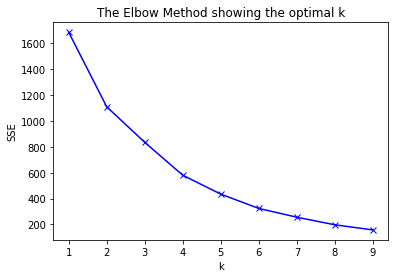

In [22]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_mod[['logerror']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [23]:
df_mod.cluster_target.value_counts()

3    60664
2     3649
0     2366
1      139
Name: cluster_target, dtype: int64

plt.hist(df_mod.cluster_target)

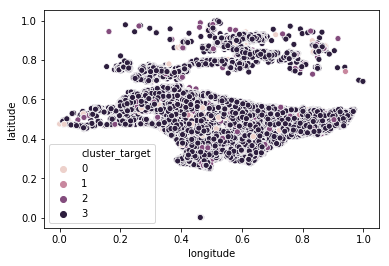

In [24]:
sns.scatterplot(data=df_mod, x='longitude', y= 'latitude', hue= 'cluster_target')

### Cluster Independent Variables

   k           sse
0  1  14179.233973
1  2   8933.262998
2  3   7204.150165
3  4   6080.841446
4  5   5478.542622
5  6   4988.854272
6  7   4629.246192
7  8   4300.932290
8  9   4103.043838


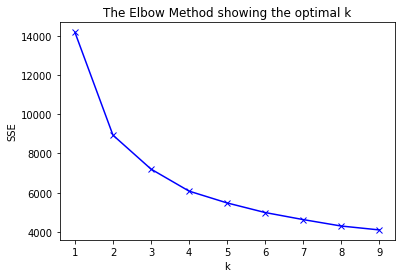

In [25]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_mod[['logerror','latitude', 'longitude', 'regionidzip', 
                   'taxvaluedollarcnt', 'bednbath', 'age',
                   'price_per_sqft_structure','price_per_sqft_land']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [26]:
kmeans2 = KMeans(n_clusters=4, random_state=123)

kmeans2.fit(df_mod[['logerror','latitude', 'longitude', 'regionidzip', 
                   'taxvaluedollarcnt', 'bednbath', 'age',
                   'price_per_sqft_structure','price_per_sqft_land']])

df_mod['house_cluster'] = kmeans2.predict(df_mod[['logerror','latitude', 'longitude', 'regionidzip', 
                   'taxvaluedollarcnt', 'bednbath', 'age',
                   'price_per_sqft_structure','price_per_sqft_land']])

kmeans2.inertia_

6080.8609680593045

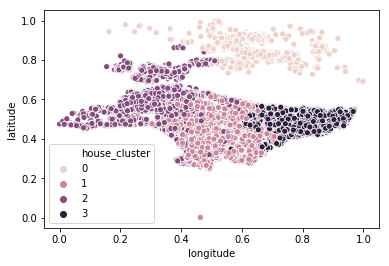

In [27]:
sns.scatterplot(data=df_mod, x='longitude', y= 'latitude', hue= 'house_cluster')

   k         sse
0  1  696.764983
1  2  257.697436
2  3  130.031347
3  4   77.947259
4  5   50.359669
5  6   35.711345
6  7   26.964324
7  8   20.894736
8  9   16.375861


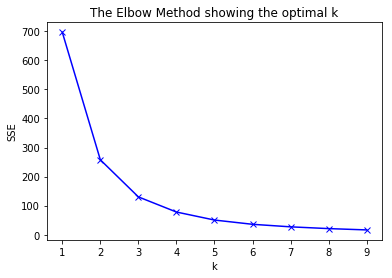

In [28]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_mod[['taxvaluedollarcnt']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

   k        sse
0  1  89.393913
1  2  44.674349
2  3  26.119466
3  4  17.300563
4  5  12.179850
5  6   8.696074
6  7   6.367824
7  8   4.974378
8  9   3.873180


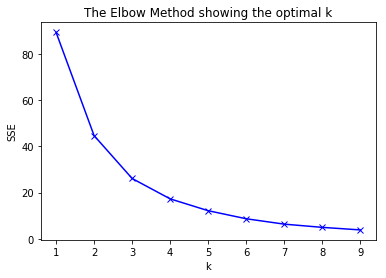

In [29]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_mod[['price_per_sqft_structure']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

   k         sse
0  1  133.804236
1  2   62.706168
2  3   35.866978
3  4   21.631862
4  5   13.727913
5  6    9.598532
6  7    7.326387
7  8    5.723479
8  9    4.397716


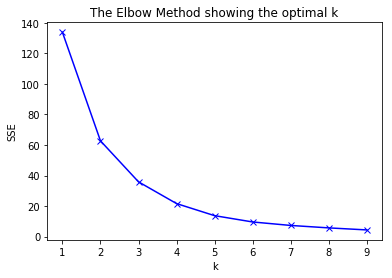

In [30]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_mod[['price_per_sqft_land']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

   k          sse
0  1  1883.765347
1  2   650.832174
2  3   272.321208
3  4   171.653637
4  5   112.618321
5  6    76.461059
6  7    58.516685
7  8    40.700596
8  9    30.629933


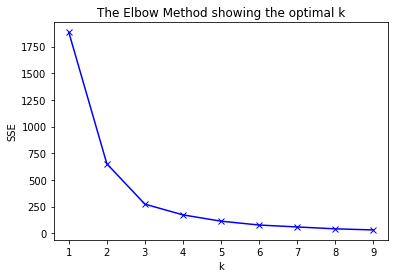

In [31]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_mod[['age']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

   k          sse
0  1  7847.340063
1  2  3634.141697
2  3  2405.830648
3  4  1895.167935
4  5  1611.421101
5  6  1391.319263
6  7  1260.172247
7  8  1161.412567
8  9  1069.030276


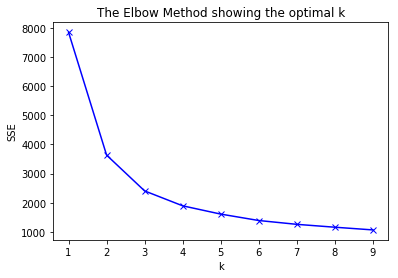

In [32]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_mod[['age', 'bednbath', 'regionidzip']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [33]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(df_mod[['taxvaluedollarcnt']])
df_mod['cluster_tax'] = kmeans.predict(df_mod[['taxvaluedollarcnt']])

In [34]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(df_mod[['price_per_sqft_structure']])
df_mod['cluster_sqft_structure'] = kmeans.predict(df_mod[['price_per_sqft_structure']])

In [35]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(df_mod[['price_per_sqft_land']])
df_mod['cluster_sqft_land'] = kmeans.predict(df_mod[['price_per_sqft_land']])

In [36]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(df_mod[['age']])
df_mod['cluster_age'] = kmeans.predict(df_mod[['age']])

In [37]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(df_mod[['regionidzip']])
df_mod['cluster_zip'] = kmeans.predict(df_mod[['regionidzip']])

In [38]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(df_mod[['age', 'bednbath', 'regionidzip']])
df_mod['cluster_combo'] = kmeans.predict(df_mod[['age', 'bednbath', 'regionidzip']])

In [39]:
df_mod.head()

,logerror,latitude,longitude,regionidzip,taxvaluedollarcnt,bednbath,price_per_sqft_structure,price_per_sqft_land,age,log_bin,age_bin,cluster_target,house_cluster,cluster_tax,cluster_sqft_structure,cluster_sqft_land,cluster_age,cluster_zip,cluster_combo
0,0.0276,0.636323,0.334132,0.284875,0.074171,0.250000,0.047374,0.027915,0.425373,2,3,3,2,1,2,0,0,0,2
2,-0.0040,0.538483,0.583719,0.228341,0.019154,0.250000,0.016162,0.004485,0.567164,1,8,3,1,1,2,0,1,0,2
5,-0.2705,0.358447,0.402414,0.093245,0.552247,0.500000,0.196203,0.512343,0.253731,0,1,0,2,2,1,1,2,2,0
6,0.0440,0.378320,0.553715,0.080029,0.017234,0.083333,0.031309,0.006224,0.574627,3,8,3,1,1,2,0,1,2,2
10,0.3825,0.557661,0.342524,0.325991,0.015959,0.166667,0.023894,0.005403,0.462687,3,5,2,2,1,2,0,0,0,2


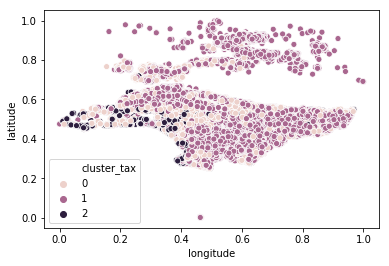

In [40]:
sns.scatterplot(data=df_mod, y='latitude', x='longitude', hue='cluster_tax')

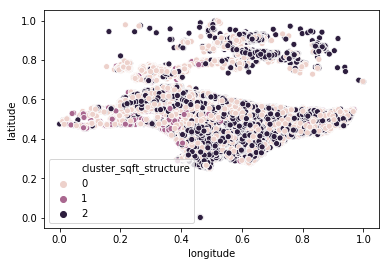

In [41]:
sns.scatterplot(data=df_mod, y='latitude', x='longitude', hue='cluster_sqft_structure')

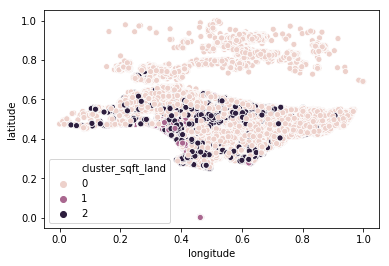

In [42]:
sns.scatterplot(data=df_mod, y='latitude', x='longitude', hue='cluster_sqft_land')

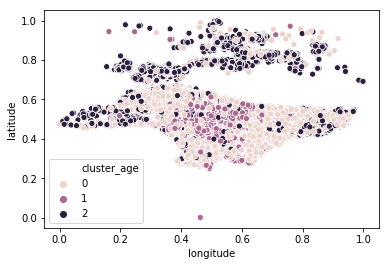

In [43]:
sns.scatterplot(data=df_mod, y='latitude', x='longitude', hue='cluster_age')

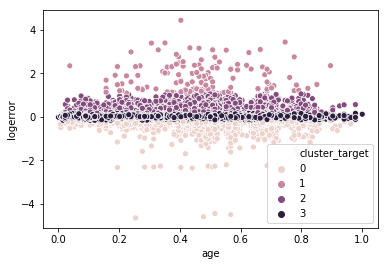

In [44]:
sns.scatterplot(data=df_mod, y='logerror', x='age', hue='cluster_target')

### Test the Significance of Clusters


In [45]:
tbl = pd.crosstab(df_mod['cluster_target'], df_mod['age'])

stat, p, dof, expected = stats.chi2_contingency(tbl)

print(stat)
print(p)


1314.8438221528513
1.496083967627829e-100


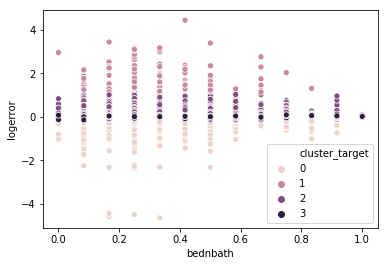

In [46]:
sns.scatterplot(data=df_mod, y='logerror', x='bednbath', hue='cluster_target')

In [47]:
tbl = pd.crosstab(df_mod['cluster_target'], df_mod['bednbath'])

stat, p, dof, expected = stats.chi2_contingency(tbl)

print(stat)
print(p)


402.5855209332812
1.7052187455588388e-63


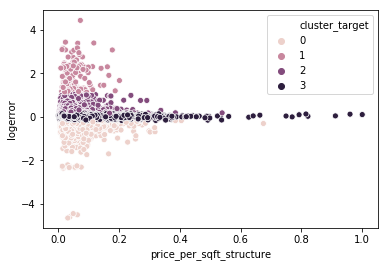

In [48]:
sns.scatterplot(data=df_mod, y='logerror', x='price_per_sqft_structure', hue='cluster_target')

In [49]:
tbl = pd.crosstab(df_mod['cluster_target'], df_mod['price_per_sqft_structure'])

stat, p, dof, expected = stats.chi2_contingency(tbl)

print(stat)
print(p)


198070.50479449998
0.6472072973560256


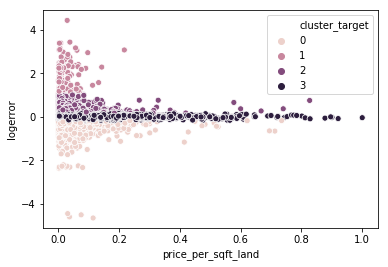

In [50]:
sns.scatterplot(data=df_mod, y='logerror', x='price_per_sqft_land', hue='cluster_target')

In [51]:
tbl = pd.crosstab(df_mod['cluster_target'], df_mod['price_per_sqft_land'])

stat, p, dof, expected = stats.chi2_contingency(tbl)

print(stat)
print(p)


199229.15898180506
0.5884740116335941


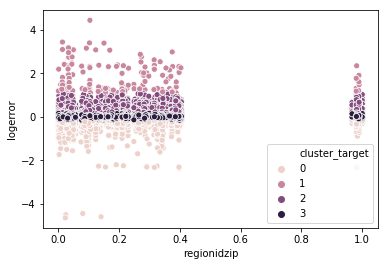

In [52]:
sns.scatterplot(data=df_mod, y='logerror', x='regionidzip', hue='cluster_target')

In [53]:
tbl = pd.crosstab(df_mod['cluster_target'], df_mod['regionidzip'])

stat, p, dof, expected = stats.chi2_contingency(tbl)

print(stat)
print(p)


3160.54848941574
7.694079150153374e-274


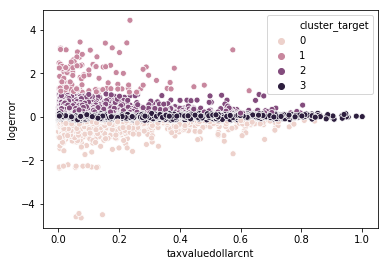

In [54]:
sns.scatterplot(data=df_mod, y='logerror', x='taxvaluedollarcnt', hue='cluster_target')

In [55]:
tbl = pd.crosstab(df_mod['cluster_target'], df_mod['taxvaluedollarcnt'])

stat, p, dof, expected = stats.chi2_contingency(tbl)

print(stat)
print(p)


156247.26141928052
6.381939419634371e-92


In [56]:
tbl = pd.crosstab(df_mod['cluster_target'], df_mod['cluster_combo'])

stat, p, dof, expected = stats.chi2_contingency(tbl)

print(stat)
print(p)


188.20352609605482
6.130822284175828e-38


In [57]:
pearsonr(df_mod.logerror, df_mod.age)

(-0.029001558635599882, 6.474886245479046e-14)

In [58]:
pearsonr(df_mod.logerror, df_mod.price_per_sqft_structure)

(-0.027826471059596385, 6.284075103459458e-13)

In [59]:
pearsonr(df_mod.logerror, df_mod.regionidzip)

(0.014519143789650732, 0.00017458663063488393)

In [60]:
ttest_ind(df_mod.logerror, df_mod.age_bin)

Ttest_indResult(statistic=-395.7413175369624, pvalue=0.0)

In [61]:
df_mod.head()

,logerror,latitude,longitude,regionidzip,taxvaluedollarcnt,bednbath,price_per_sqft_structure,price_per_sqft_land,age,log_bin,age_bin,cluster_target,house_cluster,cluster_tax,cluster_sqft_structure,cluster_sqft_land,cluster_age,cluster_zip,cluster_combo
0,0.0276,0.636323,0.334132,0.284875,0.074171,0.250000,0.047374,0.027915,0.425373,2,3,3,2,1,2,0,0,0,2
2,-0.0040,0.538483,0.583719,0.228341,0.019154,0.250000,0.016162,0.004485,0.567164,1,8,3,1,1,2,0,1,0,2
5,-0.2705,0.358447,0.402414,0.093245,0.552247,0.500000,0.196203,0.512343,0.253731,0,1,0,2,2,1,1,2,2,0
6,0.0440,0.378320,0.553715,0.080029,0.017234,0.083333,0.031309,0.006224,0.574627,3,8,3,1,1,2,0,1,2,2
10,0.3825,0.557661,0.342524,0.325991,0.015959,0.166667,0.023894,0.005403,0.462687,3,5,2,2,1,2,0,0,0,2


In [62]:
# Dummies?

# zip_dummies = pd.get_dummies(df_mod.cluster_zip)
# df_dummies = df_mod.join(zip_dummies)

# Modeling

In [63]:
# Using the absolute value of logerror to run with regression

df_mod['abs_logerror'] = df_mod.logerror.abs()

In [64]:
# Split test/train

X = df_mod.drop(columns=['logerror', 'abs_logerror', 'log_bin'], axis=1)

y = df_mod[['abs_logerror']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.70, random_state=123)


In [65]:
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred_lm = lm.predict(X_train)

r2_lm = r2_score(y_train, y_pred_lm)
mse_lm = mean_squared_error(y_train, y_pred_lm)

print('Train:')
print("Mean squared error: %.5f" % mse_lm)
print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2_lm))

print('--'*40)
print('Test:')

y_pred_lm_test = lm.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lm_test)
print("Mean squared error: %.5f" % mse)

r2 = r2_score(y_test, y_pred_lm_test)

print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2))

Train:
Mean squared error: 0.01413
33.42% of the variance in the logerror can be explained by the stuff I selected.
--------------------------------------------------------------------------------
Test:
Mean squared error: 0.01153
35.92% of the variance in the logerror can be explained by the stuff I selected.


In [66]:
lm = LinearRegression(fit_intercept=False, normalize=True)
lm.fit(X_train, y_train)
y_pred_lm = lm.predict(X_train)

r2_lm = r2_score(y_train, y_pred_lm)
mse_lm = mean_squared_error(y_train, y_pred_lm)

print('Train:')
print("Mean squared error: %.5f" % mse_lm)
print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2_lm))

print('--'*40)
print('Test:')

y_pred_lm_test = lm.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lm_test)
print("Mean squared error: %.5f" % mse)

r2 = r2_score(y_test, y_pred_lm_test)

print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2))

Train:
Mean squared error: 0.01505
29.08% of the variance in the logerror can be explained by the stuff I selected.
--------------------------------------------------------------------------------
Test:
Mean squared error: 0.01221
32.10% of the variance in the logerror can be explained by the stuff I selected.


In [67]:
lm = LinearRegression()
lm.fit(X_train[['latitude', 'longitude', 'regionidzip', 
                   'taxvaluedollarcnt', 'bednbath', 'age',
                   'price_per_sqft_structure','price_per_sqft_land']], y_train)
y_pred_lm = lm.predict(X_train[['latitude', 'longitude', 'regionidzip', 
                   'taxvaluedollarcnt', 'bednbath', 'age',
                   'price_per_sqft_structure','price_per_sqft_land']])

r2_lm = r2_score(y_train, y_pred_lm)
mse_lm = mean_squared_error(y_train, y_pred_lm)

print('Train:')
print("Mean squared error: %.5f" % mse_lm)
print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2_lm))

print('--'*40)
print('Test:')

y_pred_lm_test = lm.predict(X_test[['latitude', 'longitude', 'regionidzip', 
                   'taxvaluedollarcnt', 'bednbath', 'age',
                   'price_per_sqft_structure','price_per_sqft_land']])
mse = mean_squared_error(y_test, y_pred_lm_test)
print("Mean squared error: %.5f" % mse)

r2 = r2_score(y_test, y_pred_lm_test)

print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2))

Train:
Mean squared error: 0.02100
1.05% of the variance in the logerror can be explained by the stuff I selected.
--------------------------------------------------------------------------------
Test:
Mean squared error: 0.01770
1.59% of the variance in the logerror can be explained by the stuff I selected.


In [68]:
lm = linear_model.BayesianRidge()
lm.fit(X_train, y_train)
y_pred_lm = lm.predict(X_train)

r2_lm = r2_score(y_train, y_pred_lm)
mse_lm = mean_squared_error(y_train, y_pred_lm)

print('Train:')
print("Mean squared error: %.5f" % mse_lm)
print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2_lm))

print('--'*40)
print('Test:')

y_pred_lm_test = lm.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lm_test)
print("Mean squared error: %.5f" % mse)

r2 = r2_score(y_test, y_pred_lm_test)

print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2))

Train:
Mean squared error: 0.01414
33.41% of the variance in the logerror can be explained by the stuff I selected.
--------------------------------------------------------------------------------
Test:
Mean squared error: 0.01153
35.92% of the variance in the logerror can be explained by the stuff I selected.


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [69]:
lm = linear_model.HuberRegressor()
lm.fit(X_train, y_train)
y_pred_lm = lm.predict(X_train)

r2_lm = r2_score(y_train, y_pred_lm)
mse_lm = mean_squared_error(y_train, y_pred_lm)

print('Train:')
print("Mean squared error: %.5f" % mse_lm)
print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2_lm))

print('--'*40)
print('Test:')

y_pred_lm_test = lm.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lm_test)
print("Mean squared error: %.5f" % mse)

r2 = r2_score(y_test, y_pred_lm_test)

print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2))

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train:
Mean squared error: 0.01482
30.17% of the variance in the logerror can be explained by the stuff I selected.
--------------------------------------------------------------------------------
Test:
Mean squared error: 0.01195
33.54% of the variance in the logerror can be explained by the stuff I selected.


In [70]:
lm = linear_model.PassiveAggressiveRegressor()
lm.fit(X_train, y_train)
y_pred_lm = lm.predict(X_train)

r2_lm = r2_score(y_train, y_pred_lm)
mse_lm = mean_squared_error(y_train, y_pred_lm)

print('Train:')
print("Mean squared error: %.5f" % mse_lm)
print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2_lm))

print('--'*40)
print('Test:')

y_pred_lm_test = lm.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lm_test)
print("Mean squared error: %.5f" % mse)

r2 = r2_score(y_test, y_pred_lm_test)

print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2))

Train:
Mean squared error: 0.01651
22.25% of the variance in the logerror can be explained by the stuff I selected.
--------------------------------------------------------------------------------
Test:
Mean squared error: 0.01415
21.31% of the variance in the logerror can be explained by the stuff I selected.


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
